In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, precision_score,
                            recall_score, f1_score, roc_auc_score, 
                            average_precision_score, ConfusionMatrixDisplay,
                            PrecisionRecallDisplay, RocCurveDisplay,
                            mean_squared_error, mean_absolute_error, r2_score)

# warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

# Hide warning temporarily
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("data/flights_sample_10k.csv")

In [4]:
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])
df["YEAR"] = df["FL_DATE"].dt.year
df["MONTH"] = df["FL_DATE"].dt.month

# Phân tích dự đoán (Predictive / Machine Learning)
## 1. Phân loại (Classification):
Mặc định mọi mô hình classification trong sklearn (Logistic Regression, Random Forest, XGBoost…) đều dùng threshold = 0.5
### 1.1 Xây dựng mô hình dự đoán chuyến bay có delay >15 phút (0/1)

In [3]:
df['TARGET'] = (df['DEP_DELAY'] > 15).astype(int)

In [5]:
X = df[['MONTH', 'AIRLINE', 'ORIGIN','DEST','DEP_TIME','DISTANCE','CRS_DEP_TIME']]
y = df['TARGET']

# Xử lý Nan 
# Tách cột numeric và categorical
numeric_features = ['DEP_TIME', 'DISTANCE', 'CRS_DEP_TIME', 'MONTH']
categorical_features = ['AIRLINE', 'ORIGIN', 'DEST']

# Numeric: điền median
X[numeric_features] = SimpleImputer(strategy='median').fit_transform(X[numeric_features])

# Categorical: điền giá trị thường gặp
X[categorical_features] = SimpleImputer(strategy='most_frequent').fit_transform(X[categorical_features])

In [6]:
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (8000, 653)
X_test shape:  (2000, 653)
y_train shape:  (8000,)
y_test shape:  (2000,)


In [7]:
def metrics_calculator(y_test, pred, proba, model_name):
    '''
    This function calculates all desired performance metrics for a given model.
    '''
    result = pd.DataFrame(data=[roc_auc_score(y_test, proba),
                                average_precision_score(y_test, proba),
                                confusion_matrix(y_test, pred),
                                accuracy_score(y_test, pred),
                                precision_score(y_test, pred, average='macro'),
                                recall_score(y_test, pred, average='macro'),
                                f1_score(y_test, pred, average='macro')],
                          index=['ROC-AUC','PR-AUC','Confusion Matrix',
                                 'Accuracy','Precision','Recall','F1-score'],
                          columns = [model_name])
    return result

In [8]:
def metrics_plots(model, model_name):
    fig, axes = plt.subplots(1, 3, figsize=(14, 5), dpi=100)
    
    # Confusion Matrix 
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, colorbar=False, 
                                          cmap='Purples_r', ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].grid(False)
    
    # Precision-Recall Curve 
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[1], 
                                          name=model_name)
    axes[1].set_title("Precision–Recall Curve")
    
    # ROC Curve 
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[2], 
                                   name=model_name)
    axes[2].set_title("ROC Curve")
    
    plt.tight_layout()
    plt.show()

### Logistic Regression -> vượt trội

In [9]:
lr_model =  LogisticRegression(max_iter = 200, n_jobs = -1)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)[:,1]

metrics_calculator(y_test, lr_pred, lr_proba, 'Logistic Regression')

,Logistic Regression
ROC-AUC,0.814528
PR-AUC,0.5231
Confusion Matrix,"[[1660, 11], [292, 37]]"
Accuracy,0.8485
Precision,0.810622
Recall,0.55294
F1-score,0.556327


In [10]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1671
           1       0.77      0.11      0.20       329

    accuracy                           0.85      2000
   macro avg       0.81      0.55      0.56      2000
weighted avg       0.84      0.85      0.80      2000



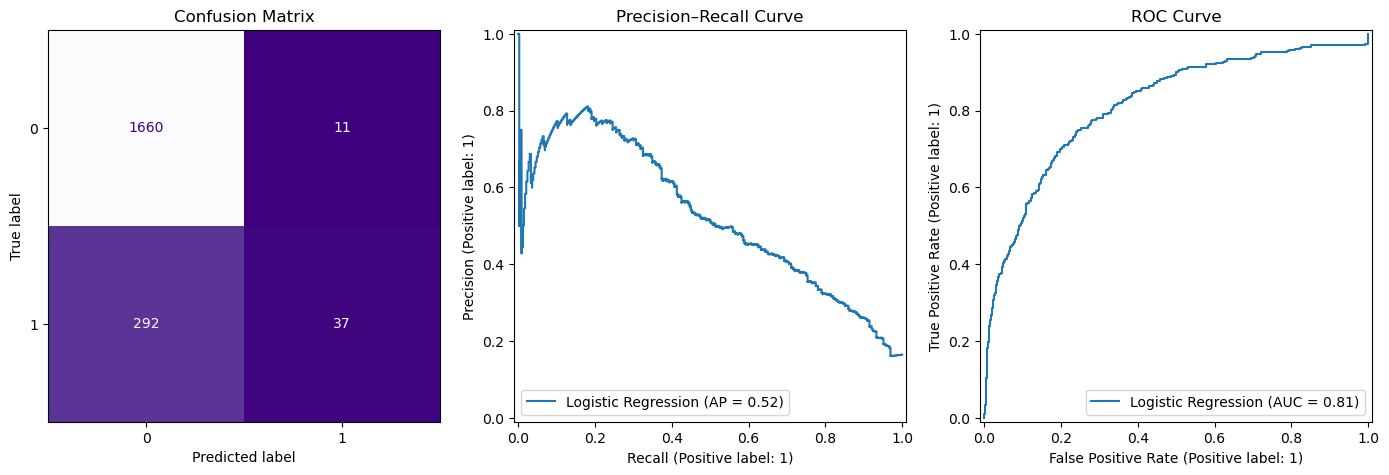

In [11]:
metrics_plots(lr_model, 'Logistic Regression')

#### Điều chỉnh threshold giúp gì?

- Tăng recall (bắt nhiều delay hơn)
- Giảm FN (giảm rủi ro thực tế)
- Điều khiển trade-off recall vs precision
- Tối ưu mô hình theo mục tiêu business thật
- Biến mô hình mạnh thành mô hình hiệu quả khi deploy<br>
=> Threshold ↓ => Recall ↑<br>
Threshold ↓ => Precision ↓

In [12]:
# Giảm threshold xuống 0.3
# => Giảm threshold xuống 0.3 → Logistic Regression cải thiện rõ rệt
# Vì LR là model tuyến tính → threshold ảnh hưởng rất mạnh.

lr_model_1 =  LogisticRegression(max_iter=200, n_jobs=-1)
lr_model_1.fit(X_train, y_train)
lr_pred_1 = lr_model_1.predict(X_test)
lr_proba_1 = lr_model_1.predict_proba(X_test)[:,1]

# thử threshold = 0.3, mặc định là 0.5
threshold = 0.3
y_pred_thresh = (lr_proba_1 >= threshold).astype(int)

metrics_calculator(y_test, y_pred_thresh, lr_proba_1, 'Logistic Regression')

,Logistic Regression
ROC-AUC,0.814528
PR-AUC,0.5231
Confusion Matrix,"[[1574, 97], [193, 136]]"
Accuracy,0.855
Precision,0.737233
Recall,0.677662
F1-score,0.699817


In [13]:
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1671
           1       0.58      0.41      0.48       329

    accuracy                           0.85      2000
   macro avg       0.74      0.68      0.70      2000
weighted avg       0.84      0.85      0.84      2000



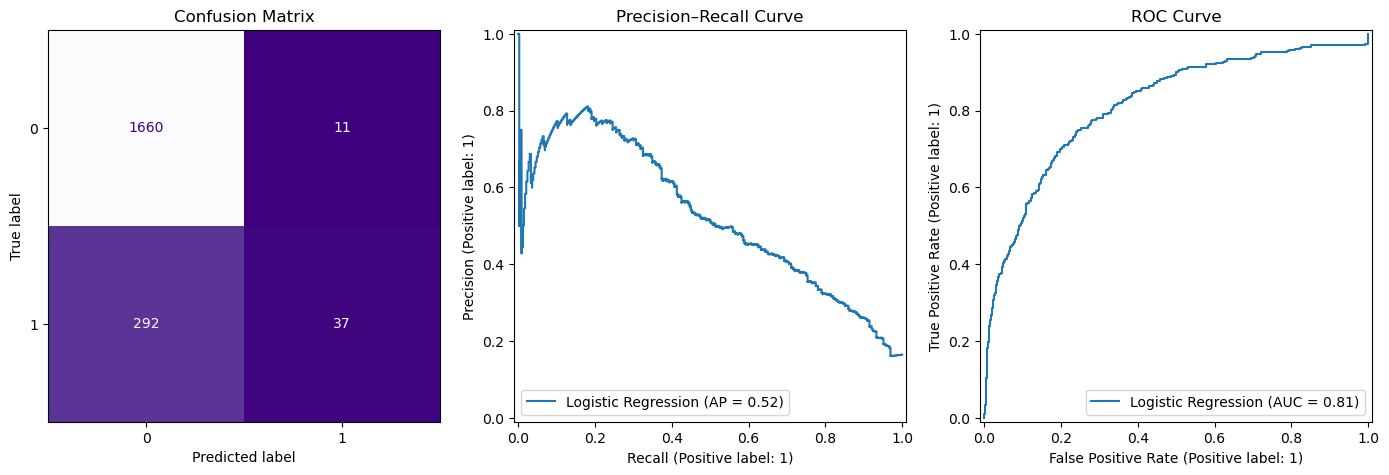

In [14]:
metrics_plots(lr_model_1, 'Logistic Regression')

### Random Forest Classifier 

In [15]:
rfc_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfc_model.fit(X_train, y_train)
rfc_pred = rfc_model.predict(X_test)
rfc_proba = rfc_model.predict_proba(X_test)[:,1]

metrics_calculator(y_test, rfc_pred, rfc_proba, 'Random Forest')

,Random Forest
ROC-AUC,0.815389
PR-AUC,0.477979
Confusion Matrix,"[[1655, 16], [293, 36]]"
Accuracy,0.8455
Precision,0.770949
Recall,0.549924
F1-score,0.551797


In [16]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1671
           1       0.69      0.11      0.19       329

    accuracy                           0.85      2000
   macro avg       0.77      0.55      0.55      2000
weighted avg       0.82      0.85      0.80      2000



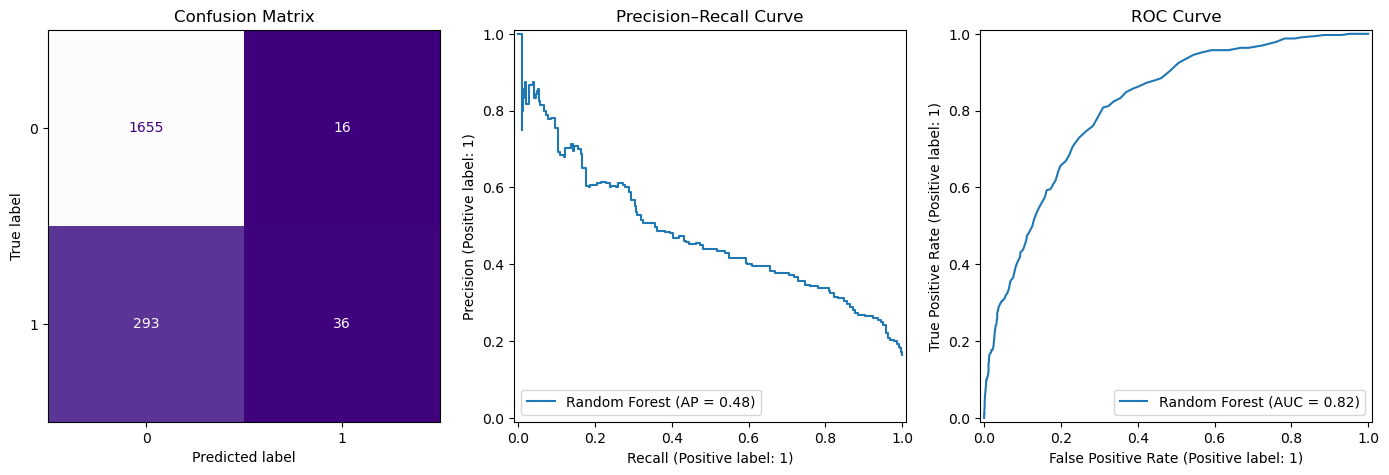

In [17]:
metrics_plots(rfc_model, 'Random Forest')

In [18]:
# Giảm threshold xuống 0.3
# Random Forest cải thiện ít
# Vì RF vốn tự tin thấp hơn → probability distribution khác.

rfc_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfc_model.fit(X_train, y_train)
rfc_pred = rfc_model.predict(X_test)
rfc_proba = rfc_model.predict_proba(X_test)[:,1]

# thử threshold = 0.3, mặc định là 0.5
threshold = 0.3
y_pred_thresh = (rfc_proba >= threshold).astype(int)

metrics_calculator(y_test, y_pred_thresh, rfc_proba, 'Random Forest')

,Random Forest
ROC-AUC,0.815389
PR-AUC,0.477979
Confusion Matrix,"[[1527, 144], [196, 133]]"
Accuracy,0.83
Precision,0.683195
Recall,0.65904
F1-score,0.669384


In [19]:
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1671
           1       0.48      0.40      0.44       329

    accuracy                           0.83      2000
   macro avg       0.68      0.66      0.67      2000
weighted avg       0.82      0.83      0.82      2000



### XGBoost -> gần như hoàn hảo

In [20]:
import xgboost as xgb

In [21]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic',seed = 42)
xgb_model.fit(X_train,y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:,1]

metrics_calculator(y_test, xgb_pred, xgb_proba, 'XGBoost')

,XGBoost
ROC-AUC,0.989714
PR-AUC,0.977767
Confusion Matrix,"[[1667, 4], [44, 285]]"
Accuracy,0.976
Precision,0.980222
Recall,0.931934
F1-score,0.954069


In [22]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1671
           1       0.99      0.87      0.92       329

    accuracy                           0.98      2000
   macro avg       0.98      0.93      0.95      2000
weighted avg       0.98      0.98      0.98      2000



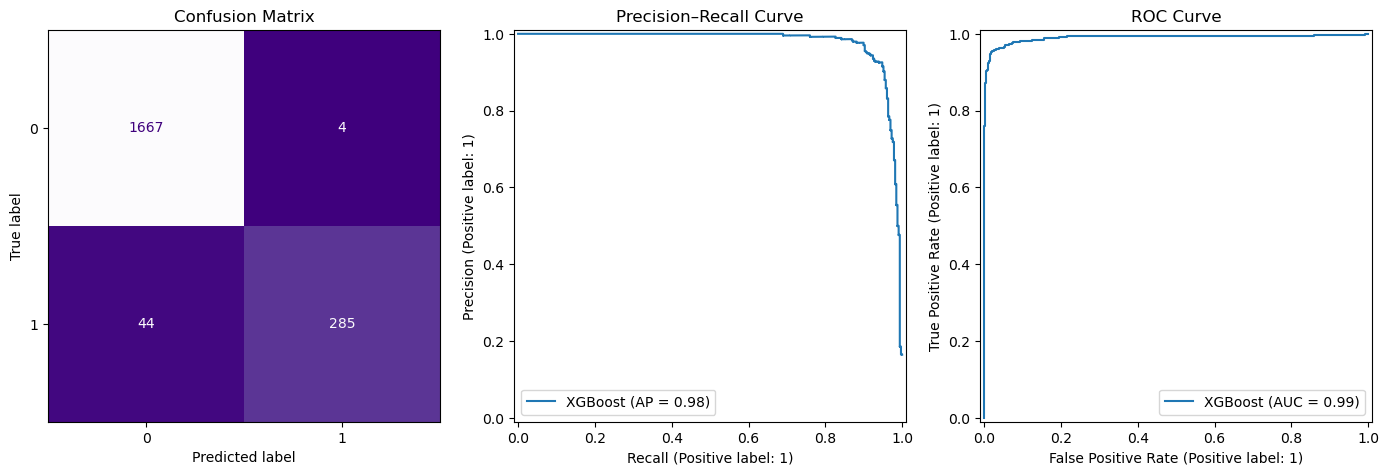

In [23]:
metrics_plots(xgb_model, 'XGBoost')

### 1.2 Các đặc trưng nào (giờ khởi hành, hãng, sân bay, tháng, distance) ảnh hưởng mạnh nhất đến khả năng delay?

In [24]:
# Logistic Regression
coefs = lr_model.coef_[0]
feature_names = X_train.columns
importance = sorted(zip(feature_names, coefs), key=lambda x: abs(x[1]), reverse=True)
for f, v in importance[:10]:
    print(f, v)

AIRLINE_Endeavor Air Inc. -0.6073038864970968
AIRLINE_Republic Airline -0.5258606983842017
ORIGIN_MDW 0.4557291783434614
DEST_BWI -0.43570564619666846
DEST_SLC -0.4208960536614581
ORIGIN_DEN 0.4014869842528008
ORIGIN_MCI -0.3667316278665473
DEST_MDW 0.3665619876852785
DEST_TPA 0.3649470692174688
DEST_SJC -0.36102286465961864


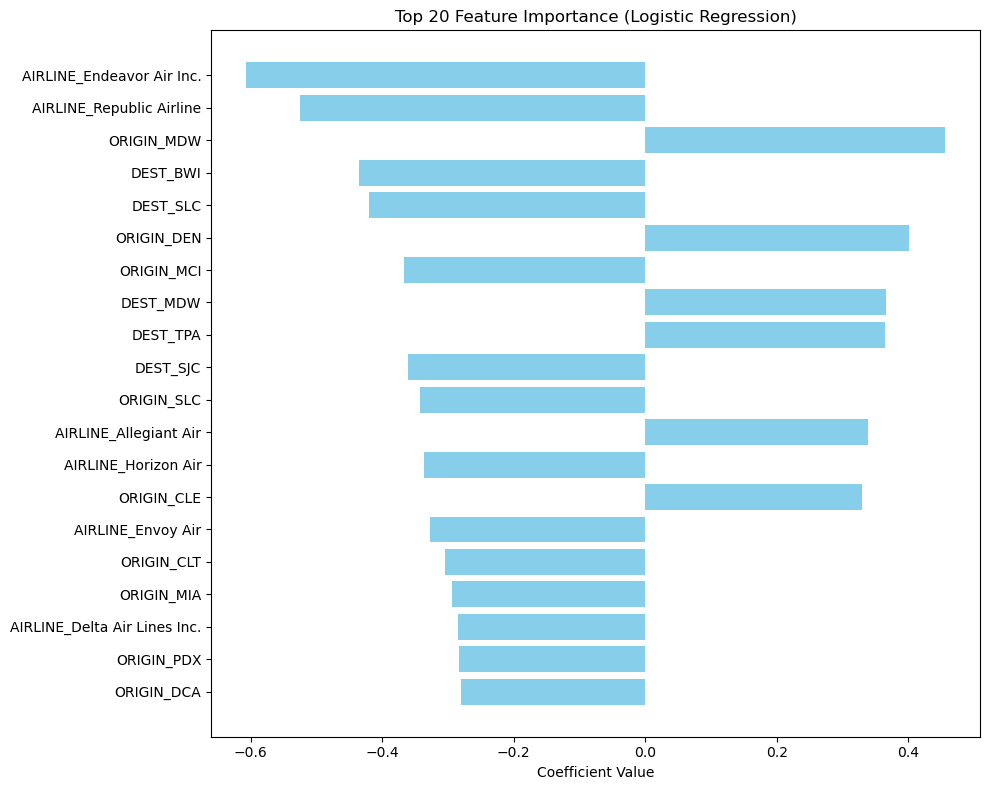

In [25]:
# Lấy coef từ Logistic Regression
coefs = lr_model.coef_[0]
feature_names = X_train.columns  # hoặc X_test.columns

# Sắp xếp index theo giá trị tuyệt đối của coef
indices = np.argsort(np.abs(coefs))[::-1]  # từ quan trọng nhất xuống

k = 20  # top 20 biến
top_indices = indices[:k]

plt.figure(figsize=(10, 8))
plt.barh(range(k), coefs[top_indices], color='skyblue')
plt.yticks(range(k), feature_names[top_indices])
plt.gca().invert_yaxis()
plt.xlabel('Coefficient Value')
plt.title('Top 20 Feature Importance (Logistic Regression)')
plt.tight_layout()
plt.show()

In [26]:
# Random Forest
importances = rfc_model.feature_importances_
importance_rfc = sorted(zip(feature_names, importances), key=lambda x: x[1], 
                       reverse=True)
for f, v in importance_rfc[:10]:
    print(f, v)

DEP_TIME 0.16834752924489968
CRS_DEP_TIME 0.16074803460068934
DISTANCE 0.08497328761486585
MONTH 0.07642288680383888
AIRLINE_Southwest Airlines Co. 0.008919576505397903
AIRLINE_Delta Air Lines Inc. 0.008023759690778945
AIRLINE_American Airlines Inc. 0.00757944255202851
AIRLINE_United Air Lines Inc. 0.006456179086200189
ORIGIN_ATL 0.006115112699493219
AIRLINE_SkyWest Airlines Inc. 0.005704516721255983


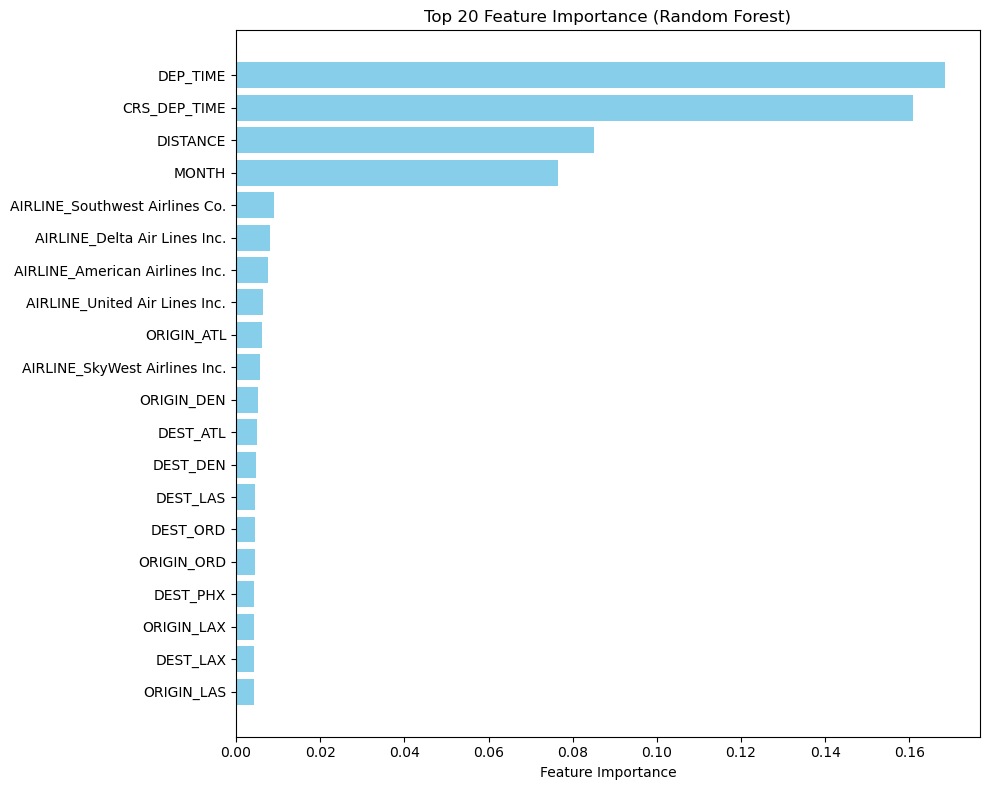

In [27]:
# Random Forest
feature_names = X_train.columns  # hoặc X.columns nếu bạn chưa split
importances = rfc_model.feature_importances_

# Sắp xếp theo quan trọng nhất
indices = np.argsort(importances)[::-1]

# Top 20
k = 20
top_indices = indices[:k]

plt.figure(figsize=(10,8))
plt.barh(range(k), importances[top_indices], color='skyblue')
plt.yticks(range(k), feature_names[top_indices])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [28]:
# XGBoost
importances = xgb_model.feature_importances_
importance_xgb = sorted(zip(feature_names, importances), key=lambda x: x[1], 
                       reverse=True)
for f, v in importance_xgb[:10]:
    print(f, v)

CRS_DEP_TIME 0.09294151
DEST_SFO 0.08339834
DEP_TIME 0.07365514
ORIGIN_OAK 0.050992392
DEST_SEA 0.029625803
AIRLINE_Southwest Airlines Co. 0.02880231
AIRLINE_Allegiant Air 0.027591497
ORIGIN_SFO 0.025768412
ORIGIN_ATL 0.020892845
ORIGIN_LAS 0.02017785


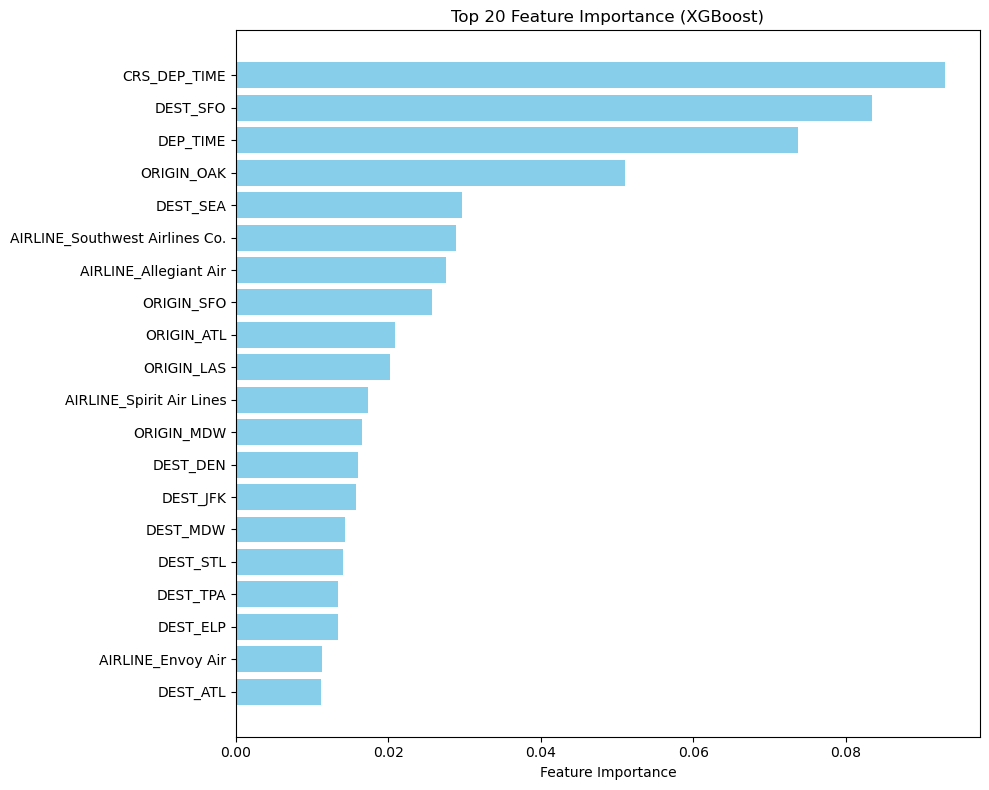

In [29]:
# Random Forest
feature_names = X_train.columns  # hoặc X.columns nếu bạn chưa split
importances = xgb_model.feature_importances_

# Sắp xếp theo quan trọng nhất
indices = np.argsort(importances)[::-1]

# Top 20
k = 20
top_indices = indices[:k]

plt.figure(figsize=(10,8))
plt.barh(range(k), importances[top_indices], color='skyblue')
plt.yticks(range(k), feature_names[top_indices])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

### Có thể dự đoán chuyến bay bị hủy dựa trên đặc trưng thời gian và sân bay không?
- ko đủ thông tin để dự đoán, cần thêm các feature khác

In [30]:
df['TARGET_1'] = (df['CANCELLED'] == 1).astype(int)

In [31]:
X1 = df[['MONTH', 'CRS_DEP_TIME', 'ORIGIN','DEST']]
y1 = df['TARGET_1']

# Xử lý Nan 
# Tách cột numeric và categorical
numeric_features = ['CRS_DEP_TIME']
categorical_features = ['MONTH', 'ORIGIN', 'DEST']

# Numeric: điền median
X1[numeric_features] = SimpleImputer(strategy='median').fit_transform(X1[numeric_features])

# Categorical: điền giá trị thường gặp
X1[categorical_features] = SimpleImputer(strategy='most_frequent').fit_transform(X1[categorical_features])

In [32]:
X1 = pd.get_dummies(X1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, 
                                                    test_size=0.2, random_state=42)

print('X_train shape: ', X1_train.shape)
print('X_test shape: ', X1_test.shape)
print('y_train shape: ', y1_train.shape)
print('y_test shape: ',y1_test.shape)

X_train shape:  (8000, 644)
X_test shape:  (2000, 644)
y_train shape:  (8000,)
y_test shape:  (2000,)


In [33]:
lr_model1 =  LogisticRegression(max_iter = 200, n_jobs = -1)
lr_model1.fit(X1_train, y1_train)
lr_pred1 = lr_model1.predict(X1_test)
lr_proba1 = lr_model1.predict_proba(X1_test)[:,1]

metrics_calculator(y1_test, lr_pred1, lr_proba1, 'Logistic Regression')

C:\flight-delay-analysis-py\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Logistic Regression
ROC-AUC,0.627294
PR-AUC,0.037883
Confusion Matrix,"[[1963, 0], [37, 0]]"
Accuracy,0.9815
Precision,0.49075
Recall,0.5
F1-score,0.495332


In [34]:
rfc_model1 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfc_model1.fit(X1_train, y1_train)
rfc_pred1 = rfc_model1.predict(X1_test)
rfc_proba1 = rfc_model1.predict_proba(X1_test)[:,1]

metrics_calculator(y1_test, rfc_pred1, rfc_proba1, 'Random Forest')

,Random Forest
ROC-AUC,0.583105
PR-AUC,0.024094
Confusion Matrix,"[[1961, 2], [37, 0]]"
Accuracy,0.9805
Precision,0.490741
Recall,0.499491
F1-score,0.495077


## 1.2 Hồi quy (Regression)
R² – chỉ số duy nhất có ngưỡng chung

Dùng cho mọi bài toán regression.

- R²	Đánh giá tổng quát
- '> 0.9	Xuất sắc
- 0.7–0.9	Tốt
- 0.5–0.7	Trung bình
- 0.3–0.5	Yếu
- 0–0.3	Rất yếu
- < 0	Tệ (model thua baseline)

### Dự đoán số phút delay (ARR_DELAY).

In [35]:
X2 = df[['MONTH', 'CRS_DEP_TIME', 'DEP_TIME', 'ORIGIN', 'DEST', 'DISTANCE']]
y2 = df['ARR_DELAY']

In [36]:
df2 = df.dropna(subset=['ARR_DELAY'])

# tạo lại X, y từ df2
X2 = df2[['MONTH', 'CRS_DEP_TIME', 'DEP_TIME', 'ORIGIN', 'DEST', 'DISTANCE']].copy()
y2 = df2['ARR_DELAY']

# Xử lý Nan 
# Tách cột numeric và categorical
num_cols = ['MONTH', 'CRS_DEP_TIME', 'DEP_TIME', 'DISTANCE']
cat_cols = ['ORIGIN', 'DEST']

# Numeric: điền median
X2[num_cols] = SimpleImputer(strategy='median').fit_transform(X2[num_cols])

# Categorical: điền giá trị thường gặp
X2[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X2[cat_cols])

In [37]:
X2 = pd.get_dummies(X2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, 
                                                    test_size=0.2, random_state=42)

print('X_train shape: ', X2_train.shape)
print('X_test shape: ', X2_test.shape)
print('y_train shape: ', y2_train.shape)
print('y_test shape: ',y2_test.shape)

X_train shape:  (7791, 628)
X_test shape:  (1948, 628)
y_train shape:  (7791,)
y_test shape:  (1948,)



=== LinearRegression ===
MAE: 23.633312156956332
RMSE: 48.058325461373855
R2: -0.03816858903364406

=== RandomForestRegressor ===
MAE: 14.45256817776742
RMSE: 24.009985704644958
R2: 0.7408719545952149

=== XGBRegressor ===
MAE: 11.72688382302432
RMSE: 19.399977099566343
R2: 0.8308262209651877


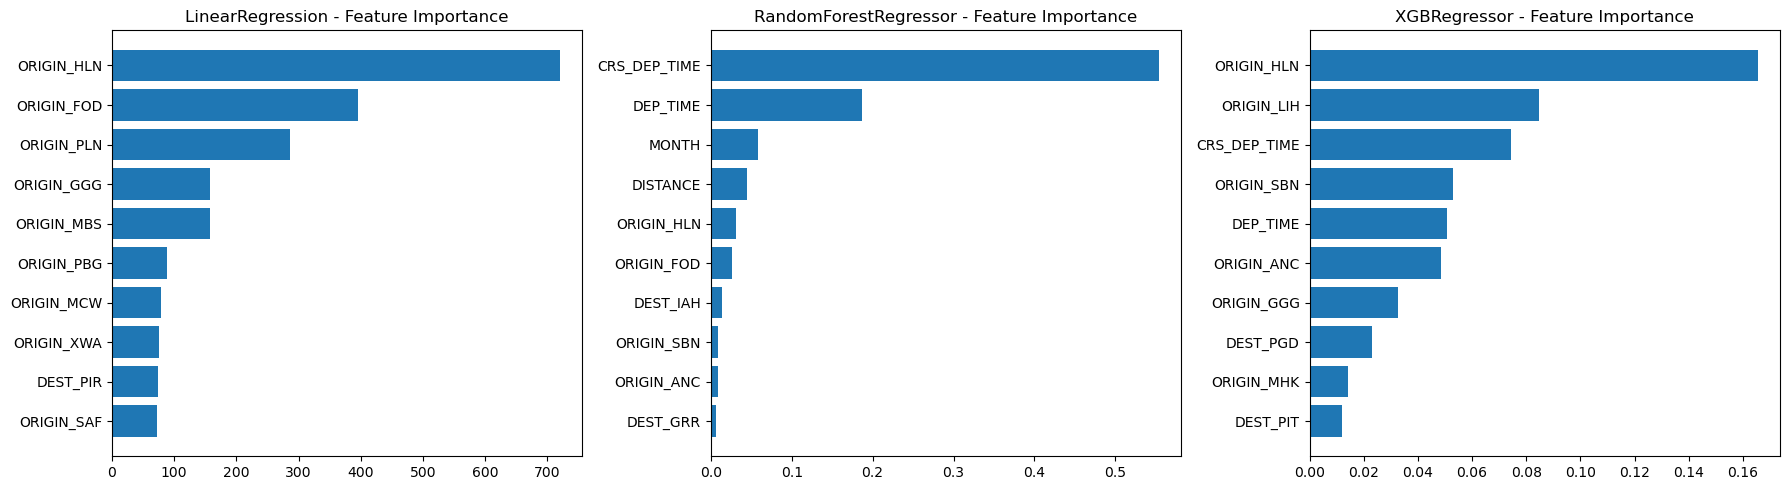

In [38]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=200, 
                                                   max_depth=12, random_state=42),
    "XGBRegressor": xgb.XGBRegressor(n_estimators=200, random_state=42)
}

results = {}
feature_importances = {}

for name, model in models.items():

    # Train
    model.fit(X2_train, y2_train)
    y2_pred = model.predict(X2_test)

    # Metrics
    mae = mean_absolute_error(y2_test, y2_pred)
    rmse = np.sqrt(mean_squared_error(y2_test, y2_pred))
    r2 = r2_score(y2_test, y2_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

    # ---- FEATURE IMPORTANCE ----
    if name == "LinearRegression":
        # importance = abs(beta)
        importance = np.abs(model.coef_)
        fi = pd.DataFrame({"Feature": X2_train.columns, "Importance": importance})
    
    elif name == "RandomForestRegressor":
        importance = model.feature_importances_
        fi = pd.DataFrame({"Feature": X2_train.columns, "Importance": importance})
    
    elif name == "XGBRegressor":
        importance = model.feature_importances_
        fi = pd.DataFrame({"Feature": X2_train.columns, "Importance": importance})

    # Sort
    fi = fi.sort_values(by="Importance", ascending=False)
    feature_importances[name] = fi


# ---- PRINT RESULTS ----
for m in results:
    print(f"\n=== {m} ===")
    for metric, value in results[m].items():
        print(f"{metric}: {value}")

# ---- PLOT FEATURE IMPORTANCE FOR ALL 3 MODELS ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=100)

for ax, (model_name, fi) in zip(axes, feature_importances.items()):
    top_fi = fi.head(10)  # top 10 feature
    ax.barh(top_fi["Feature"], top_fi["Importance"])
    ax.set_title(f"{model_name} - Feature Importance")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

### ⭐ SO SÁNH mô hình 

Model (MAE ↓, RMSE ↓, R² ↑) -> Nhận xét<br>
LinearRegression (23.63, 48.06, -0.038) -> Tệ, gần như không học được gì<br>
RandomForestRegressor (14.45, 24.01, 0.741) -> Ổn, học được nhiều mẫu<br>
XGBRegressor (11.73, 19.40, 0.831) -> Tốt nhất, dự đoán chính xác nhất

#### 💡 Tóm lại

LinearRegression hoạt động rất kém (R² < 0). Điều này cho thấy quan hệ giữa features và delay không tuyến tính.

RandomForestRegressor cải thiện đáng kể, giảm lỗi ~40% so với LinearRegression.

XGBRegressor cho hiệu suất tốt nhất, đạt R² ≈ 0.83, nghĩa là mô hình giải thích được 83% biến thiên delay — rất mạnh cho dữ liệu này.

## 1.3 Chuỗi thời gian (Time Series)
### Dự báo delay trung bình tháng tiếp theo.
#### SARIMAX

C:\flight-delay-analysis-py\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\flight-delay-analysis-py\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


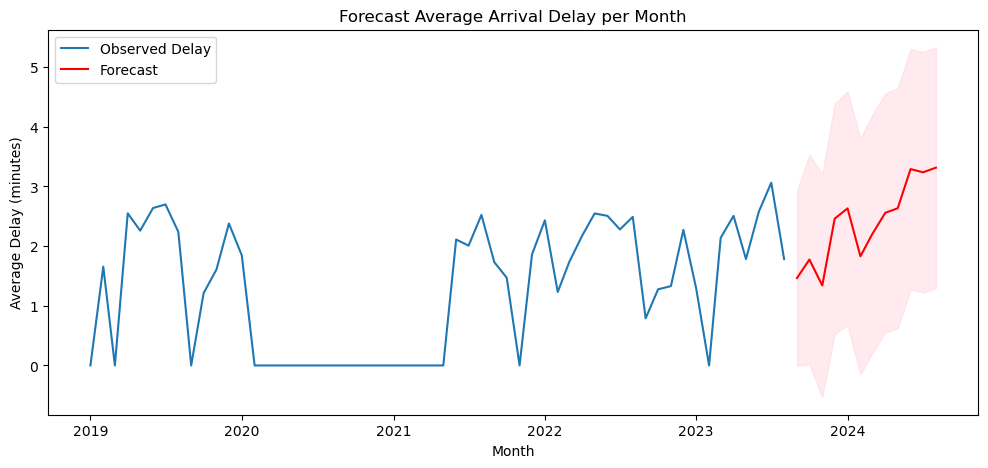

                Month  Predicted_DELAY  CI_lower  CI_upper
2023-09-01 2023-09-01         1.464558 -0.003796  2.932912
2023-10-01 2023-10-01         1.775283  0.019692  3.530874
2023-11-01 2023-11-01         1.340673 -0.532607  3.213952
2023-12-01 2023-12-01         2.461420  0.531339  4.391502
2024-01-01 2024-01-01         2.632937  0.671870  4.594005
2024-02-01 2024-02-01         1.829788 -0.151975  3.811551
2024-03-01 2024-03-01         2.206859  0.210845  4.202874
2024-04-01 2024-04-01         2.558677  0.553400  4.563955
2024-05-01 2024-05-01         2.635402  0.624240  4.646564
2024-06-01 2024-06-01         3.292013  1.277100  5.306926
2024-07-01 2024-07-01         3.237592  1.220191  5.254993
2024-08-01 2024-08-01         3.315254  1.296021  5.334487


In [39]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# 1️⃣ Load dữ liệu (giả sử df đã có cột FL_DATE và ARR_DELAY)
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# 2️⃣ Tính delay trung bình theo tháng
monthly_delay = df.groupby(df['FL_DATE'].dt.to_period('M'))['ARR_DELAY'].mean().reset_index()
monthly_delay['ARR_DELAY'] = monthly_delay['ARR_DELAY'].clip(lower=0, upper=200)  # loại bỏ outlier >200 phút
monthly_delay['FL_DATE'] = monthly_delay['FL_DATE'].dt.to_timestamp()  # chuyển về timestamp
monthly_delay['ARR_DELAY_LOG'] = np.log1p(monthly_delay['ARR_DELAY'])

# 3️⃣ Chuẩn bị series cho SARIMA
ts = monthly_delay.set_index('FL_DATE')['ARR_DELAY_LOG']

# 4️⃣ Xây dựng SARIMA model (có seasonal 12 tháng)
model = SARIMAX(ts, 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

# 5️⃣ Forecast 12 tháng tiếp theo
forecast = model_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')
forecast_df = pd.DataFrame({
    'Month': forecast_index,
    'Predicted_DELAY': forecast.predicted_mean,
    'CI_lower': forecast.conf_int().iloc[:,0],
    'CI_upper': forecast.conf_int().iloc[:,1]
})

# 6️⃣ Plot forecast
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values, label='Observed Delay')
plt.plot(forecast_df['Month'], forecast_df['Predicted_DELAY'], label='Forecast', color='red')
plt.fill_between(forecast_df['Month'], forecast_df['CI_lower'], forecast_df['CI_upper'], color='pink', alpha=0.3)
plt.title('Forecast Average Arrival Delay per Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.legend()
plt.show()

# 7️⃣ Xem kết quả forecast
print(forecast_df)


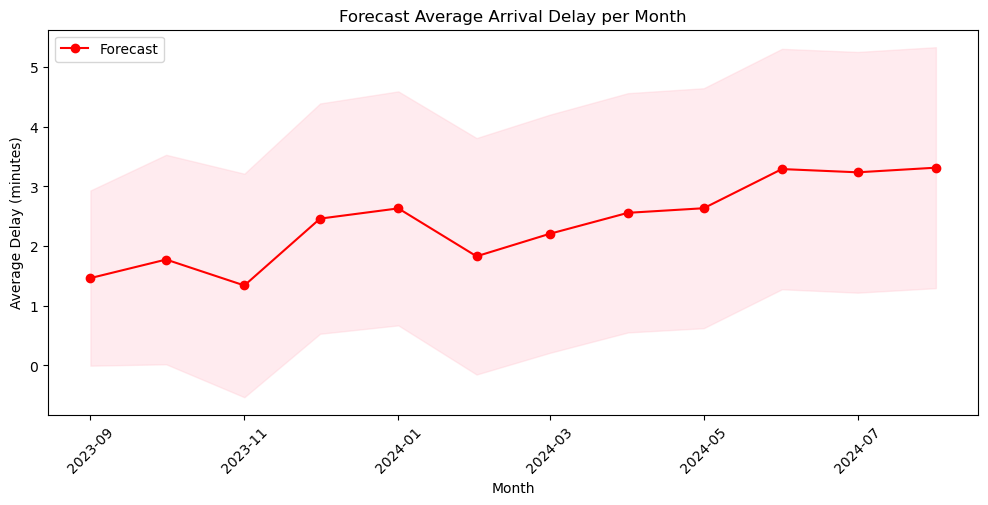

In [40]:
plt.figure(figsize=(12,5))
plt.plot(forecast_df['Month'], forecast_df['Predicted_DELAY'], label='Forecast', color='red', marker='o')
plt.fill_between(forecast_df['Month'], forecast_df['CI_lower'], forecast_df['CI_upper'], color='pink', alpha=0.3)
plt.title('Forecast Average Arrival Delay per Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### Prophet

14:55:39 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing


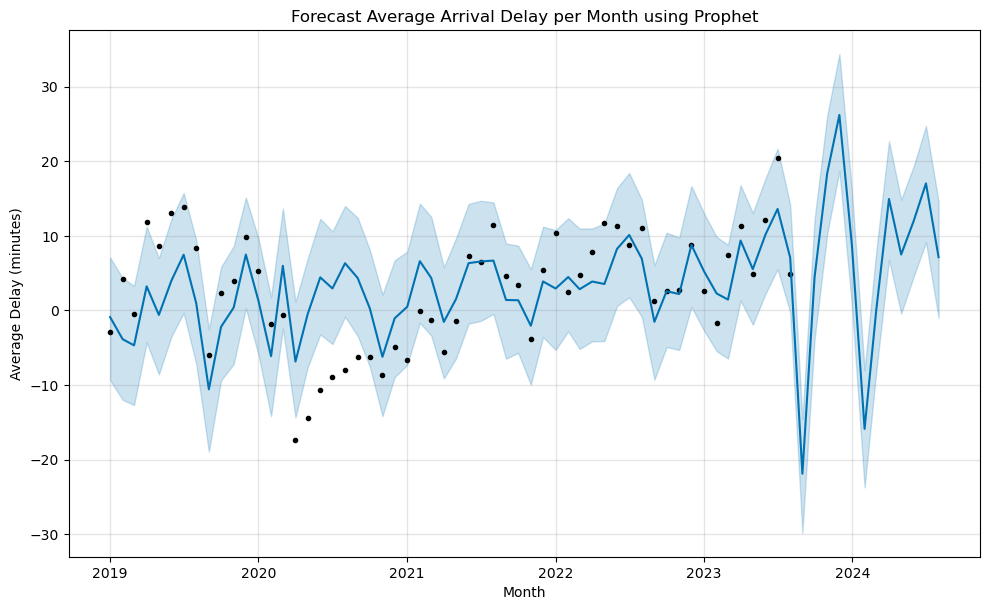

        Month  Predicted_DELAY   CI_lower   CI_upper
56 2023-08-31       -21.896932 -29.815843 -14.612121
57 2023-09-30         4.487293  -3.832298  12.251519
58 2023-10-31        18.370795  10.220555  26.096334
59 2023-11-30        26.209613  18.708060  34.387547
60 2023-12-31         8.617726   0.525682  15.939361
61 2024-01-31       -15.883732 -23.737075  -8.000713
62 2024-02-29         0.183456  -8.069033   8.069434
63 2024-03-31        14.936643   6.781327  22.689438
64 2024-04-30         7.495102  -0.419612  14.843898
65 2024-05-31        12.028047   4.577680  19.373226
66 2024-06-30        17.035968   9.121285  24.728131
67 2024-07-31         7.137375  -0.992713  14.598320


In [48]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1️⃣ Chuẩn bị dữ liệu: tính delay trung bình theo tháng
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
monthly_delay = df.groupby(df['FL_DATE'].dt.to_period('M'))['ARR_DELAY'].mean().reset_index()
monthly_delay['FL_DATE'] = monthly_delay['FL_DATE'].dt.to_timestamp()

# 2️⃣ Chuẩn hóa dữ liệu cho Prophet
prophet_df = monthly_delay.rename(columns={'FL_DATE':'ds','ARR_DELAY':'y'})

# 3️⃣ Khởi tạo model Prophet
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(prophet_df)

# 4️⃣ Tạo dataframe dự báo 12 tháng tiếp theo
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

# 5️⃣ Plot dự báo
fig = m.plot(forecast)
plt.title('Forecast Average Arrival Delay per Month using Prophet')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.show()

# 6️⃣ Xem dữ liệu forecast
forecast_df = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(12)
forecast_df.rename(columns={'ds':'Month','yhat':'Predicted_DELAY',
                            'yhat_lower':'CI_lower','yhat_upper':'CI_upper'}, inplace=True)
print(forecast_df)

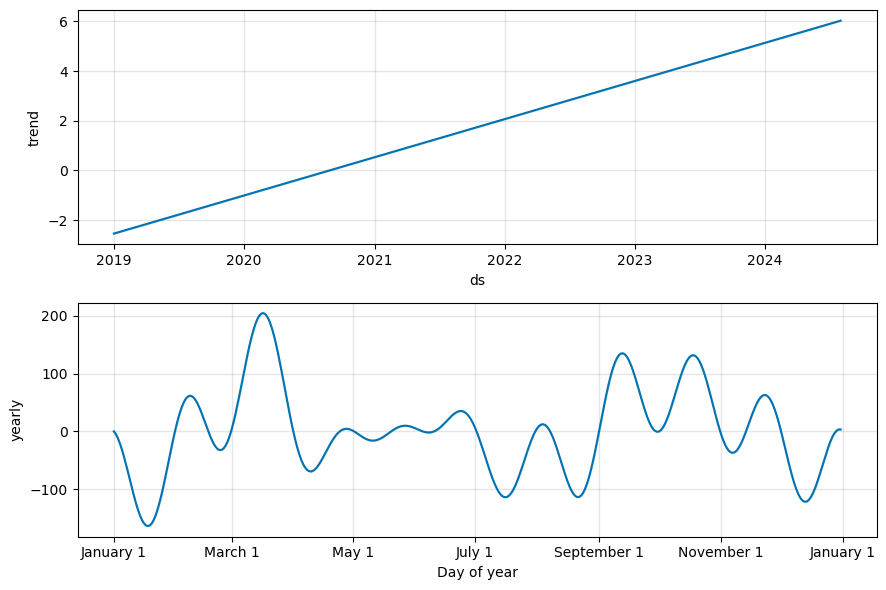

In [49]:
fig2 = m.plot_components(forecast)
plt.show()

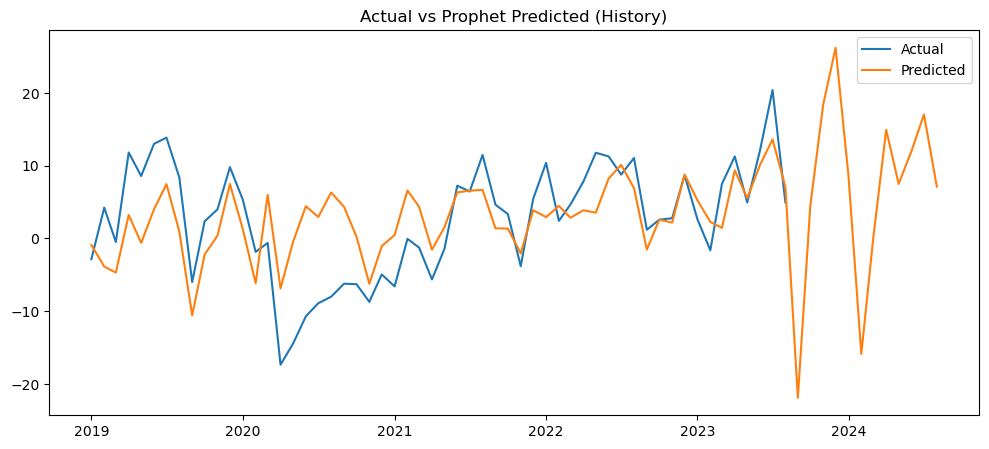

In [58]:
actual = prophet_df.set_index('ds')
pred = forecast.set_index('ds')

plt.figure(figsize=(12,5))
plt.plot(actual['y'], label='Actual')
plt.plot(pred['yhat'], label='Predicted')
plt.legend()
plt.title("Actual vs Prophet Predicted (History)")
plt.show()

### Hãng nào duy trì hiệu suất ổn định nhất qua các năm (độ lệch chuẩn delay thấp nhất)?

In [68]:
monthly_airline = df.groupby(['AIRLINE', 'YEAR'])['ARR_DELAY'].mean().reset_index()

# tính std theo hãng
std_airline = monthly_airline.groupby('AIRLINE')['ARR_DELAY'].std().reset_index()

std_airline = std_airline.rename(columns={'ARR_DELAY': 'std_delay'})
std_airline = std_airline.sort_values(by='std_delay')

print(std_airline)

                               AIRLINE  std_delay
9                          Horizon Air   0.987929
13                    Republic Airline   1.575268
3                 Delta Air Lines Inc.   2.993638
12                   PSA Airlines Inc.   3.305986
10                     JetBlue Airways   3.649494
0                 Alaska Airlines Inc.   3.769739
17               United Air Lines Inc.   6.111334
5                            Envoy Air   6.313082
14               SkyWest Airlines Inc.   6.885711
4                    Endeavor Air Inc.   7.009070
15              Southwest Airlines Co.   7.031973
2               American Airlines Inc.   9.764789
16                    Spirit Air Lines  10.026405
11                  Mesa Airlines Inc.  10.139962
1                        Allegiant Air  10.893020
7               Frontier Airlines Inc.  11.131705
6   ExpressJet Airlines LLC d/b/a aha!  15.923932
8               Hawaiian Airlines Inc.  20.699256
